In [1]:
import numpy as np
import pathlib
from PIL import Image, Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
SEED = 78
np.random.seed(SEED)

img_size = 100
batch_size = 100

data_dir = pathlib.Path("data/images_plus")

('Images: ', 22619)

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=SEED,
  image_size=(img_size, img_size),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=SEED,
  image_size=(img_size, img_size),
  batch_size=batch_size
)

Found 22619 files belonging to 33 classes.
Using 20358 files for training.
Found 22619 files belonging to 33 classes.
Using 2261 files for validation.


In [5]:
class_names = train_ds.class_names
class_names

['ა', 'ბ', 'გ', 'დ', 'ე', 'ვ', 'ზ', 'თ', 'ი', 'კ', 'ლ', 'მ', 'ნ', 'ო', 'პ', 'ჟ', 'რ', 'ს', 'ტ', 'უ', 'ფ', 'ქ', 'ღ', 'ყ', 'შ', 'ჩ', 'ც', 'ძ', 'წ', 'ჭ', 'ხ', 'ჯ', 'ჰ']


In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [58]:
np.random.seed(SEED)
def random_invert(x, chance=0.5):
  return 255-x if np.random.random() < chance else x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


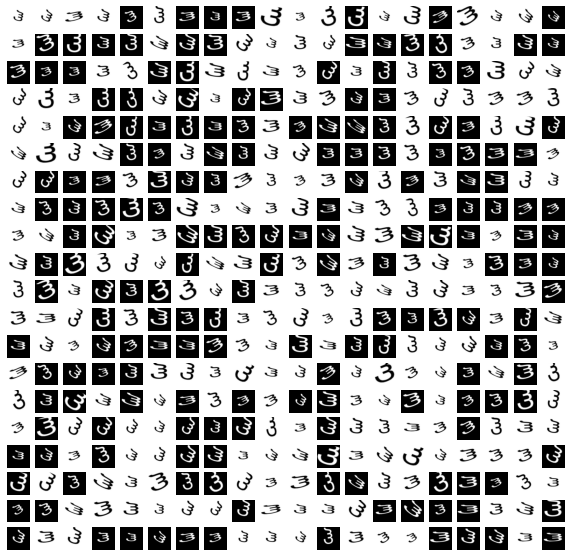

In [59]:
# Test image transformations
plt.figure(figsize=(10, 10))

# Load random test image
img = tf.keras.utils.load_img(
    'data\images_plus\ჰ\\h_!kolxeti_96.png', target_size=(100, 100)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

aug_image = Sequential([
  layers.Resizing(
    height = img_size, 
    width = img_size
  ),
  # Random zoom (most pictures were max width already, so no need to stretch too much)
  layers.RandomZoom(
    height_factor = (0.9999, -0.4), 
    width_factor = (0.9999, -0.125), 
    fill_mode='constant', 
    fill_value=255
  ),
  # Random rotation
  layers.RandomRotation(
    factor=0.1, 
    fill_mode='constant', 
    fill_value=255
  ),
  # Random inverting of colors
  layers.Lambda(
    lambda x: random_invert(x, chance=0.5)
  ),
])

x = 20
for i in range(x*x):
  augmented_image = aug_image(img_array)
  ax = plt.subplot(x, x, i + 1)
  plt.imshow(augmented_image[0] / 255)
  plt.axis("off")

In [74]:
num_classes = len(class_names)

model = Sequential([
  # Normalize
  layers.Rescaling(
    1./255, 
    input_shape=(img_size, img_size, 3)
  ),
  # Random zoom (most pictures were max width already, so no need to stretch too much)
  layers.RandomZoom(
    height_factor = (0.9999, -0.4), 
    width_factor = (0.9999, -0.125), 
    fill_mode='constant', 
    fill_value=255
  ),
  # Random rotation
  layers.RandomRotation(
    factor=0.1, 
    fill_mode='constant', 
    fill_value=255
  ),
  # Random inverting of colors
  layers.Lambda(
    lambda x: random_invert(x, chance=0.5)
  ),
  # Layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(3), # 3x3 max pooling instead of 2x2 to cut down on parameters early on
  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [75]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_13 (Rescaling)     (None, 100, 100, 3)       0         
_________________________________________________________________
random_zoom_34 (RandomZoom)  (None, 100, 100, 3)       0         
_________________________________________________________________
random_rotation_34 (RandomRo (None, 100, 100, 3)       0         
_________________________________________________________________
lambda_34 (Lambda)           (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 33, 33, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 33, 33, 32)      

In [76]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os

if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")

model_name = "aksov19_lmach19"

tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
checkpoint = ModelCheckpoint(
    os.path.join("results", f"{model_name}" + "_loss-{val_loss:.4f}_accuracy-{val_accuracy:.4f}.h5"),
    monitor="accuracy",
    save_best_only=True,
    verbose=1
)

In [77]:
# reaches 93% accuracy in 20 epochs
# current epoch is set to 200 for testing
epochs=200
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard, checkpoint]
)

Epoch 1/200
204/204 [==============================] - 88s 428ms/step - loss: 3.1757 - accuracy: 0.1116 - val_loss: 2.0332 - val_accuracy: 0.4246

Epoch 00001: accuracy improved from -inf to 0.11155, saving model to results\aksov19_lmach19_loss-2.0332_accuracy-0.4246.h5
Epoch 2/200
204/204 [==============================] - 84s 413ms/step - loss: 1.7006 - accuracy: 0.4983 - val_loss: 0.9612 - val_accuracy: 0.7116

Epoch 00002: accuracy improved from 0.11155 to 0.49833, saving model to results\aksov19_lmach19_loss-0.9612_accuracy-0.7116.h5
Epoch 3/200
204/204 [==============================] - 83s 408ms/step - loss: 1.0919 - accuracy: 0.6798 - val_loss: 0.6296 - val_accuracy: 0.8169

Epoch 00003: accuracy improved from 0.49833 to 0.67983, saving model to results\aksov19_lmach19_loss-0.6296_accuracy-0.8169.h5
Epoch 4/200
204/204 [==============================] - 84s 414ms/step - loss: 0.8524 - accuracy: 0.7527 - val_loss: 0.5713 - val_accuracy: 0.8337

Epoch 00004: accuracy improved fro

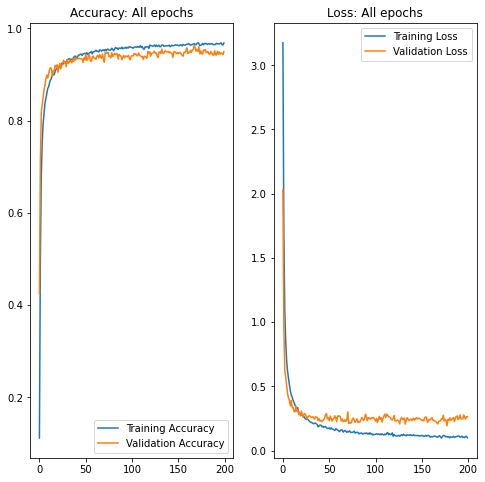

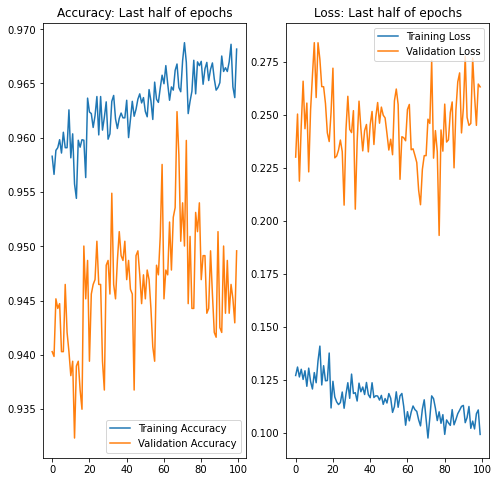

In [82]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy: All epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss: All epochs')
plt.show()

epochs_range = range(epochs//2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc[epochs//2:], label='Training Accuracy')
plt.plot(epochs_range, val_acc[epochs//2:], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy: Last half of epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss[epochs//2:], label='Training Loss')
plt.plot(epochs_range, val_loss[epochs//2:], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss: Last half of epochs')
plt.show()

In [6]:
# Model overfits the training data
# Instead of the final model we'll use the model when the validation accuracy was the highest, a.k.a about 96% (visible in the bottom left graph)
best_model = Sequential([
  # Normalize
  layers.Rescaling(
    1./255, 
    input_shape=(img_size, img_size, 3)
  ),
  # Layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  # 3x3 max pooling instead of 2x2 to cut down on parameters
  layers.MaxPooling2D(3),
  layers.Conv2D(32, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='tanh'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(33)
])
best_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

best_model.load_weights(r"aksov19_lmach19_loss-0.2077_accuracy-0.9624.h5")

In [7]:
from tqdm import tqdm
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


# Test predictions
predictions = list()
labels = list()

for i in tqdm(range(len(class_names))):
    char = class_names[i]
    for path in list(data_dir.joinpath(char).glob("*.png")):
        img = tf.keras.utils.load_img(
            path, target_size=(img_size, img_size)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = best_model.predict(img_array)
        score = tf.nn.softmax(prediction[0])

        predictions.append(np.argmax(score))
        labels.append(i)

100%|██████████| 33/33 [19:02<00:00, 34.64s/it]


In [8]:
# Confusion matrix
cm = tf.math.confusion_matrix(labels, predictions)

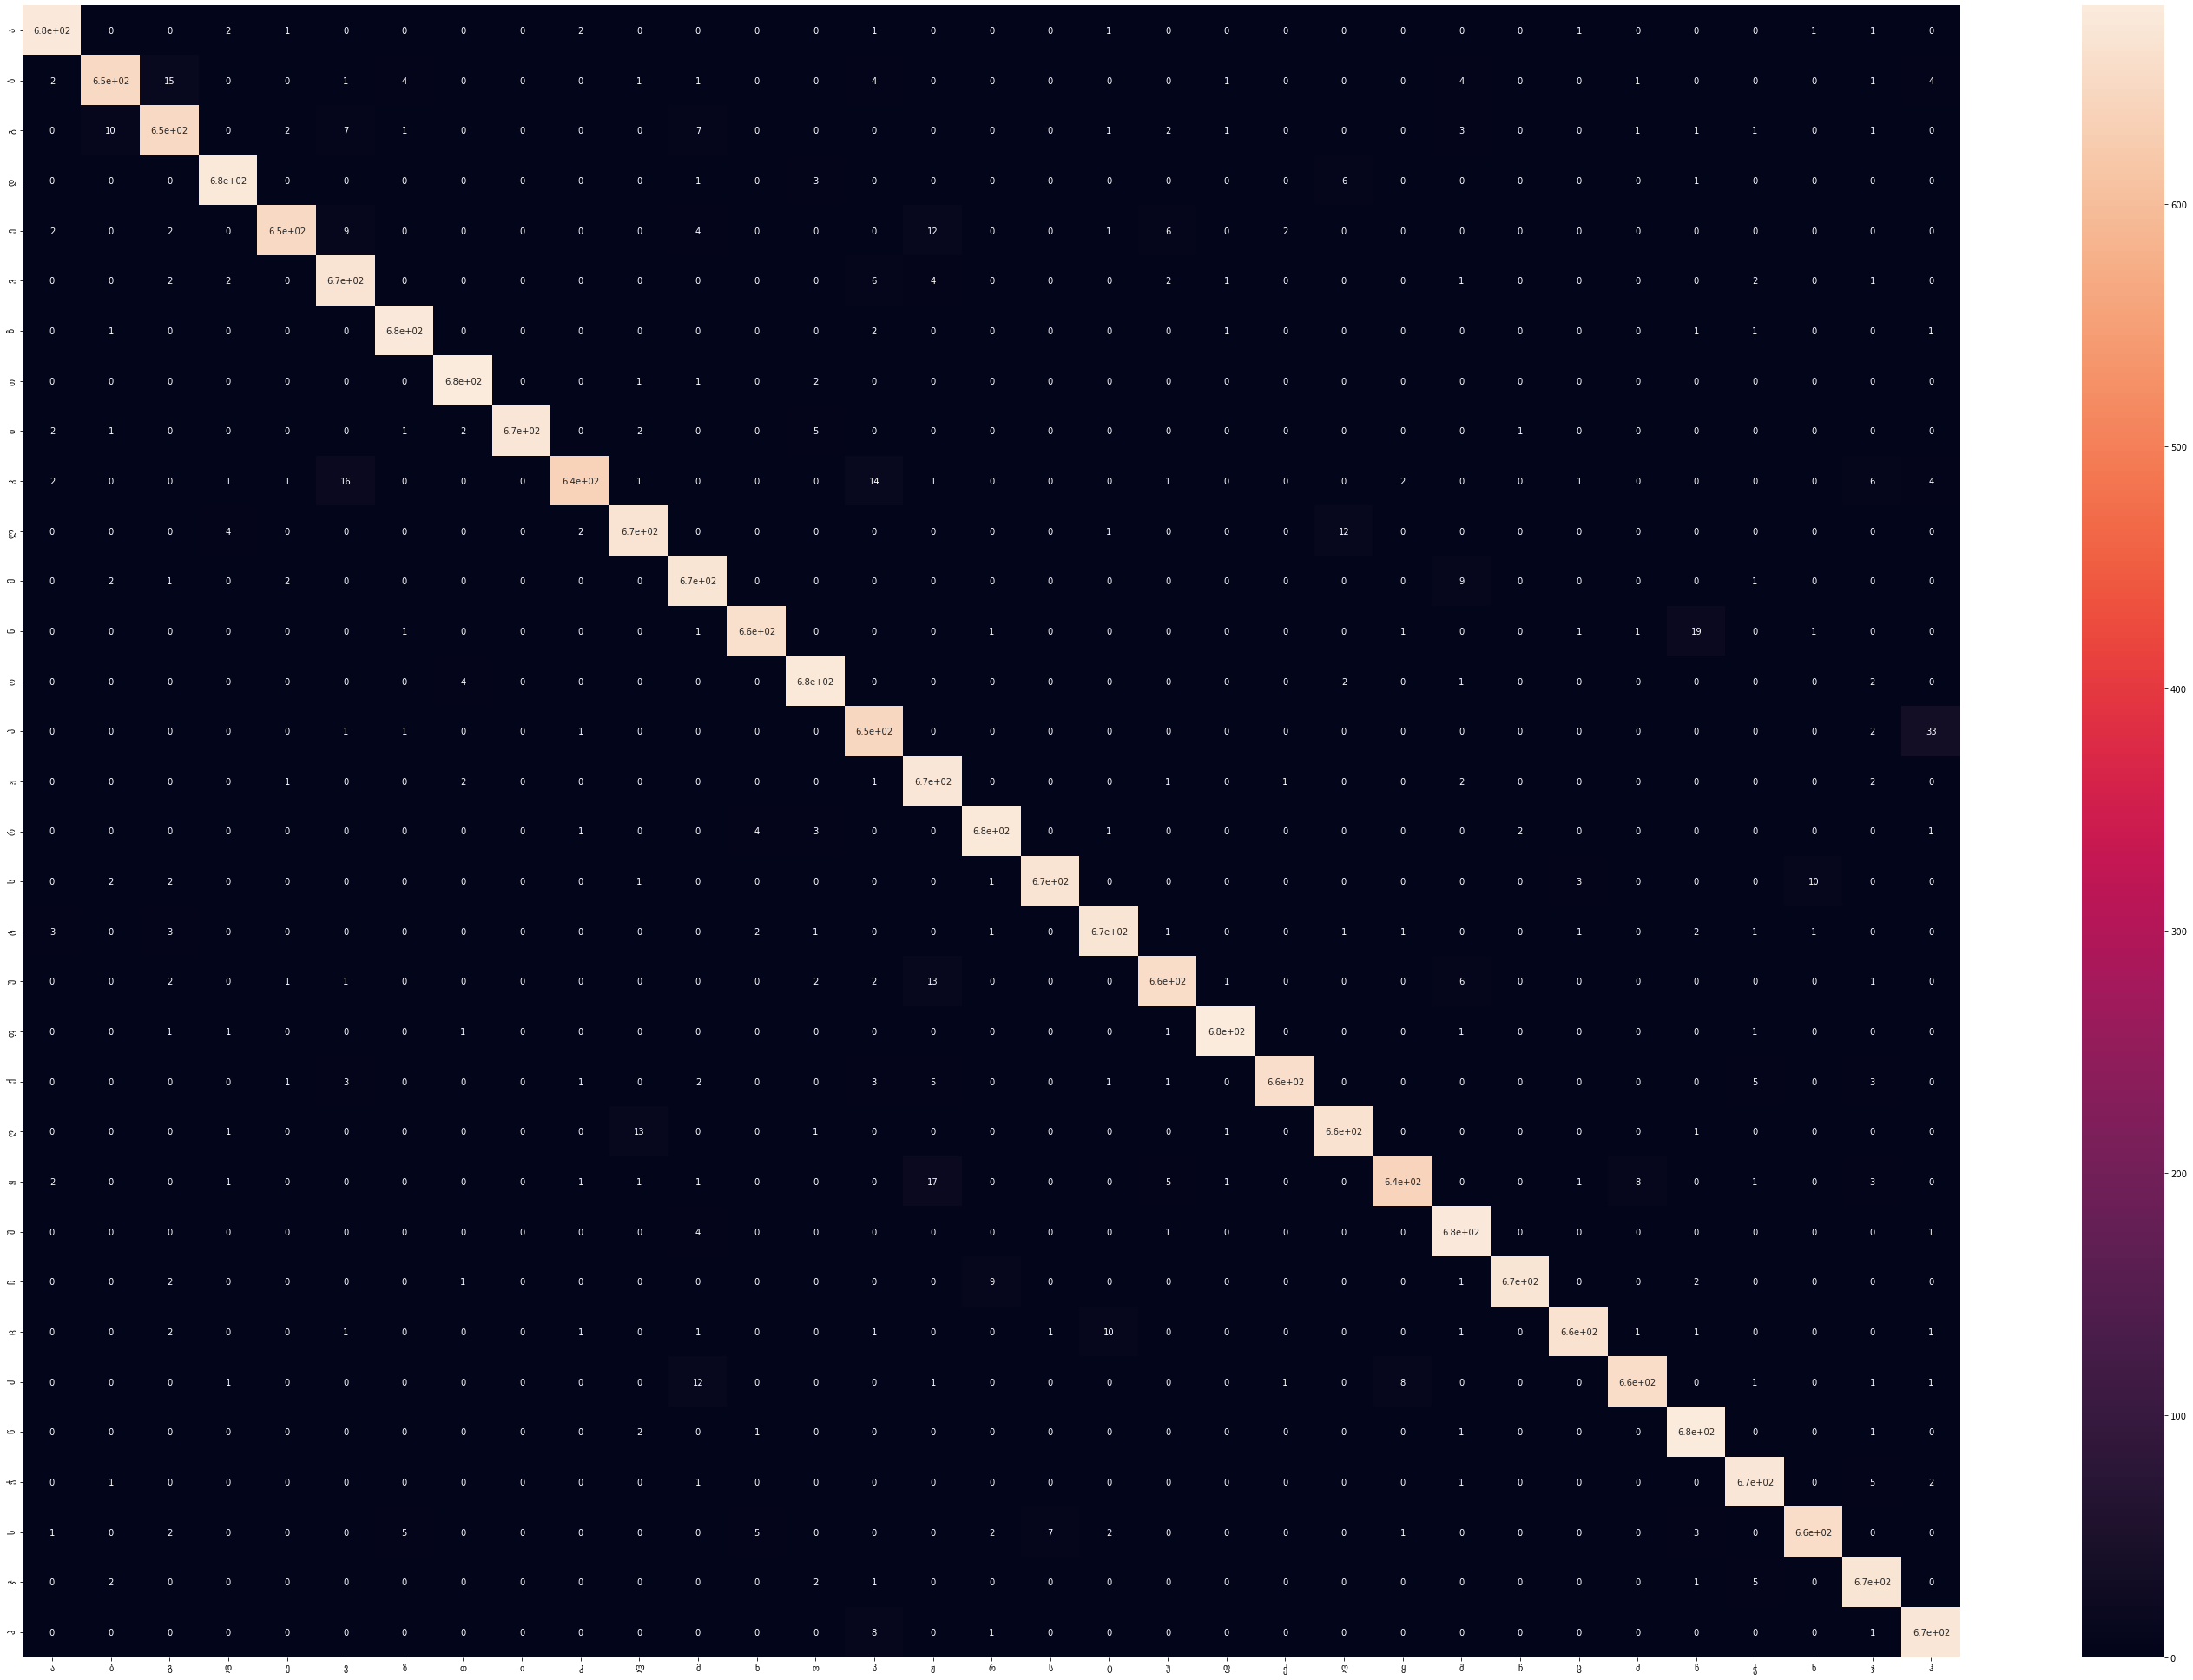

In [9]:
df_cm = pd.DataFrame(
    np.matrix(cm), 
    index = class_names,
    columns = class_names
)

plt.figure(figsize = (50,35))
sn.heatmap(df_cm, annot=True)

In [10]:
# Testing on additional images (not used in the model and not filtered properly)
test_dir = pathlib.Path("data/images_mine")

predictions_2 = list()
labels_2 = list()

for i in tqdm(range(len(class_names))):
    char = class_names[i]
    for path in list(test_dir.joinpath(char).glob("*.png")):
        img = tf.keras.utils.load_img(
            path, target_size=(img_size, img_size)
        )
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        prediction = best_model.predict(img_array)
        score = tf.nn.softmax(prediction[0])

        predictions_2.append(np.argmax(score))
        labels_2.append(i)

100%|██████████| 33/33 [35:26<00:00, 64.44s/it]


In [13]:
cm_2 = tf.math.confusion_matrix(labels_2, predictions_2)

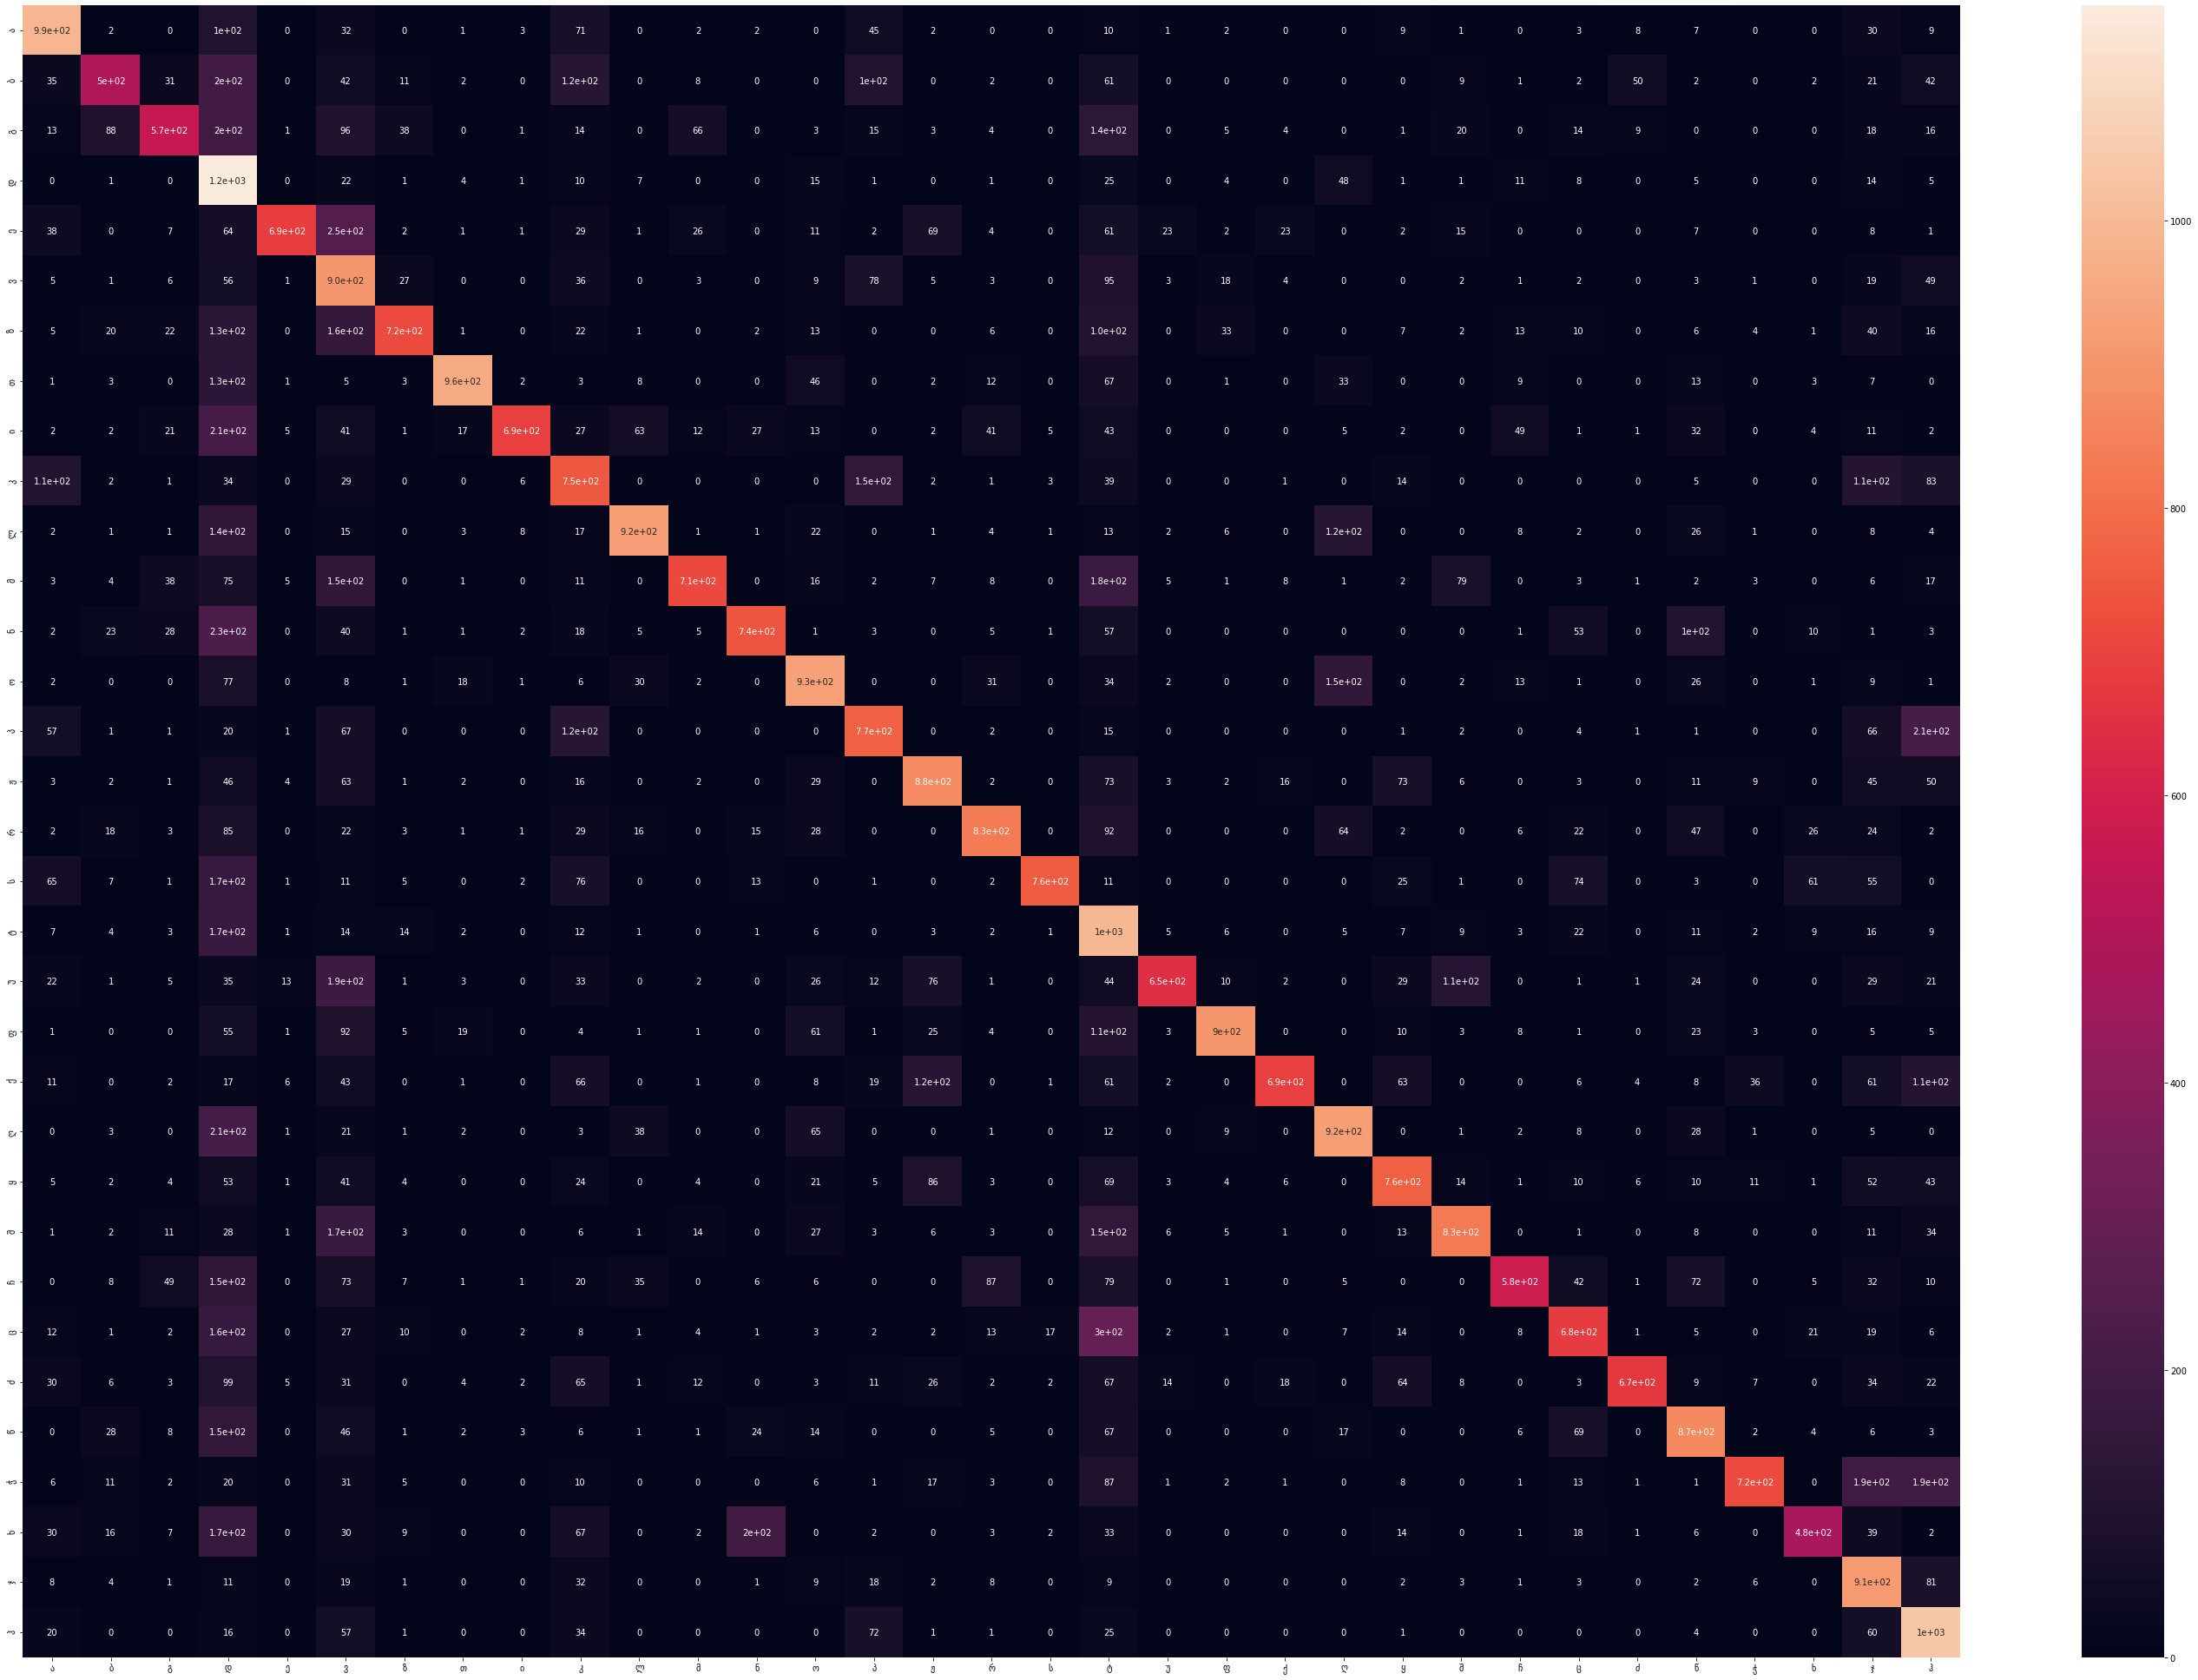

In [14]:
df_cm = pd.DataFrame(
    np.matrix(cm_2), 
    index = class_names,
    columns = class_names
)

plt.figure(figsize = (50,35))
sn.heatmap(df_cm, annot=True)